# Hit 结构

转换成可变长的数据结构，节省空间，并且更利于分析

## 代码

```c++
#include <TFile.h>
#include <TTree.h>

const int chp = 48;

int main(int argc, char **argv) {
	Double_t pe[chp];
	Double_t cpe[chp];
	Int_t phit, pid[chp];
	Double_t per[chp], cper[chp];


	TFile *ipf = new TFile("../data/s4c.root", "read");
	TTree *ipt = (TTree*)ipf->Get("tree");
	ipt->SetBranchAddress("cpe", pe);

	TFile *ipfc = new TFile("../data/s4calibration.root", "read");
	TTree *iptc = (TTree*)ipfc->Get("tree");
	iptc->SetBranchAddress("ccpe", cpe);

	TFile *opf = new TFile("../data/s4Hit.root", "recreate");
	TTree *opt = new TTree("tree", "alpha hit tree");
	opt->Branch("phit", &phit, "phit/I");
	opt->Branch("pid", pid, "pid[phit]/I");
	opt->Branch("pe", per, "pe[phit]/D");
	opt->Branch("cpe", cper, "cpe[phit]/D");

	Long64_t nentry = ipt->GetEntries();
	Long64_t nentry100 = nentry / 100;
	printf("filling   0%%");
	fflush(stdout);
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", jentry / nentry100);
			fflush(stdout);
		}
		ipt->GetEntry(jentry);
		iptc->GetEntry(jentry);
		phit = 0;
		for (int i = 0; i != chp; ++i) {
			if (pe[i] > 0) {
				pid[phit] = i;
				per[phit] = pe[i];
				cper[phit] = cpe[i];
				++phit;
			}
		}
		opt->Fill();
	}
	printf("\n");

	opt->Write();
	opf->Close();
	ipf->Close();
	ipfc->Close();
}

```

## 分析

In [1]:
TCanvas *c1 = new TCanvas;
TFile *ipf = new TFile("../data/s4Hit.root", "read");
TTree *tree = (TTree*)ipf->Get("tree");
tree->Print();

******************************************************************************
*Tree    :tree      : alpha hit tree                                         *
*Entries :  5790825 : Total =       164576062 bytes  File  Size =   76213059 *
*        :          : Tree compression factor =   2.16                       *
******************************************************************************
*Br    0 :phit      : phit/I                                                 *
*Entries :  5790825 : Total  Size=   23189081 bytes  File Size  =    2500667 *
*Baskets :      280 : Basket Size=    1802240 bytes  Compression=   9.27     *
*............................................................................*
*Br    1 :pid       : pid[phit]/I                                            *
*Entries :  5790825 : Total  Size=   37564291 bytes  File Size  =   10801654 *
*Baskets :      711 : Basket Size=   25600000 bytes  Compression=   3.48     *
*...................................................

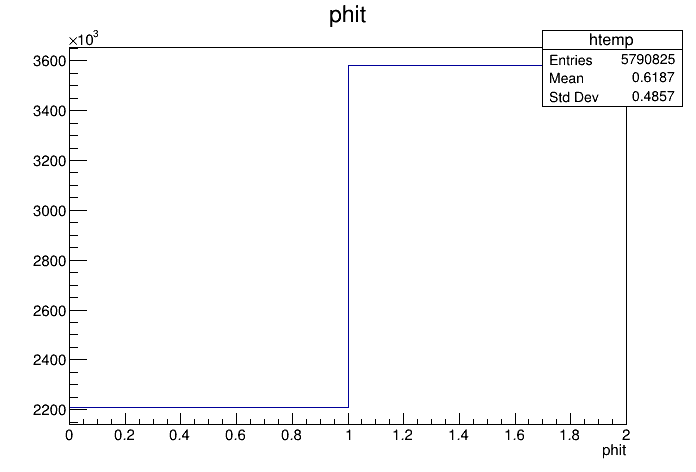

In [2]:
tree->Draw("phit");
c1->Draw();

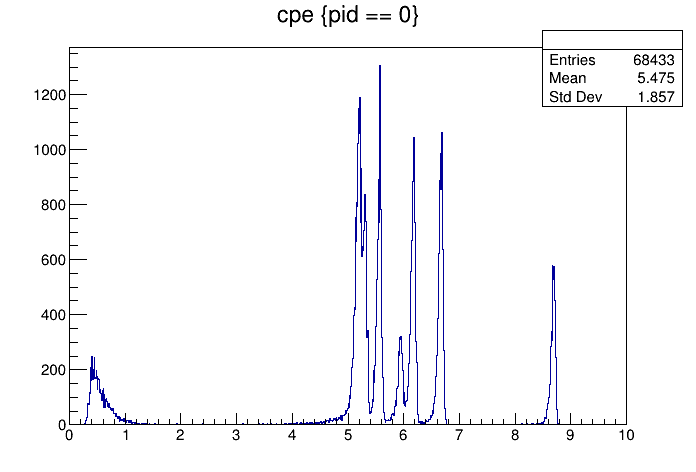

In [3]:
tree->Draw("cpe>>(1000, 0, 10)", "pid == 0");
c1->Draw();

### 刻度效果

In [4]:
%jsroot on
tree->Draw("pe:pid>>(48, 0, 48, 800, 0, 1600)", "", "colz");
c1->SetLogz();
c1->Draw();

In [5]:
tree->Draw("cpe:pid>>(48, 0, 48, 1000, 0, 10)", "", "colz");
c1->Draw();

In [6]:
ipf->Close();